## Experiments on RCVs

Notebook for the last experiment on the regression of concept measures of texture in the network layers. Results in interpretability_results/rcvs

In [1]:
#importing keras, tensorflow and configuring GPU device
import keras
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
configtf = tf.ConfigProto()
configtf.gpu_options.allow_growth = True
configtf.gpu_options.visible_device_list = "0"
set_session(tf.Session(config=configtf))

#standard libraries
import numpy as np
import os
from PIL import Image
import scipy.ndimage as nd
import matplotlib.pyplot as plt
import sys
import requests
from StringIO import StringIO

#regression libraries
import statsmodels.api as sm

#libraries to compute concept measures
import skimage.color
import skimage
from skimage.feature import greycomatrix, greycoprops

def linear_regression(inputs, y, random_state=1234, verbose=0):
    inputs = sm.add_constant(inputs)
    model = sm.OLS(y,inputs)
    results = model.fit()
    return results.rsquared

def standardPreprocess(data):

	print '[models] Appling some standard preprocessing to the data. '
	preprocessedData = np.asarray([keras.applications.inception_v3.preprocess_input(x) for x in data])
	print '[models] data mean: ', np.mean(preprocessedData)
	print '[models] data std: ', np.std(preprocessedData)
    
''' deprecated 
import sys
sys.path.append('../../camnet/')
from models import *
'''


def compute_concept_measures(x_test):
    concept_measures={}
    concept_measures['dissimilarity']=[]
    concept_measures['contrast']=[]
    concept_measures['homogeneity']=[]
    concept_measures['ASM']=[]
    concept_measures['energy']=[]
    concept_measures['correlation']=[]
    for i in range(len(x_test)):
        glcm = greycomatrix(skimage.img_as_ubyte(skimage.color.rgb2gray(x_test[i])), [1], [0] , symmetric=True, normed=True)
        concept_measures['dissimilarity'].append(greycoprops(glcm, 'dissimilarity'))
        concept_measures['contrast'].append(greycoprops(glcm, 'contrast'))
        concept_measures['homogeneity'].append(greycoprops(glcm, 'homogeneity'))
        concept_measures['ASM'].append( greycoprops(glcm, 'ASM'))
        concept_measures['energy'].append( greycoprops(glcm, 'energy'))
        concept_measures['correlation'].append(greycoprops(glcm, 'correlation'))
    for k in concept_measures.keys():
        concept_measures[k] = np.asarray(concept_measures[k]).T[0][0]
    return concept_measures

/home/mara/venv/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
### LOADING MODEL FINETUNED
keras.backend.clear_session()
model_finetuned = keras.applications.inception_v3.InceptionV3(include_top=True, weights=None, input_tensor=None, input_shape=None, pooling=None, classes=1)
model_finetuned.load_weights('../../camnet/inceptionv3_30epochs/tumor_classifier.h5')

In [6]:
### LOADING DATASET 
import h5py 
db=h5py.File('/mnt/nas2/results/IntermediateResults/Camelyon/all500/patches.hdf5', 'r')
def print_info(name, obj):
    print name 
'''DATASET INFO'''
db.visititems(print_info)

all_normal_patches
all_tumor_patches
normal
normal/level7
normal/level7/centre0
normal/level7/centre0/patient004
normal/level7/centre0/patient004/node4
normal/level7/centre0/patient004/node4/locations
normal/level7/centre0/patient004/node4/patches
normal/level7/centre0/patient009
normal/level7/centre0/patient009/node1
normal/level7/centre0/patient009/node1/locations
normal/level7/centre0/patient009/node1/patches
normal/level7/centre0/patient010
normal/level7/centre0/patient010/node4
normal/level7/centre0/patient010/node4/locations
normal/level7/centre0/patient010/node4/patches
normal/level7/centre0/patient012
normal/level7/centre0/patient012/node0
normal/level7/centre0/patient012/node0/locations
normal/level7/centre0/patient012/node0/patches
normal/level7/centre0/patient015
normal/level7/centre0/patient015/node1
normal/level7/centre0/patient015/node1/locations
normal/level7/centre0/patient015/node1/patches
normal/level7/centre0/patient015/node2
normal/level7/centre0/patient015/node2/lo

In [77]:
def get_avg_pool_activation(bc_model, inputs, layer_name, batch_size=32):
    l=layer_name
    get_layer_output = K.function([bc_model.layers[0].input],
                                  [bc_model.get_layer(l).output])
    
    val_batch_no = 0
    start_batch = val_batch_no
    end_batch = start_batch + batch_size
    tot_val_batches = len(inputs)/batch_size
    avgp_feats = []

    if len(bc_model.get_layer(l).output.shape)<=2:
        space = np.zeros((len(inputs), bc_model.get_layer(l).output.shape[-1]))
    else:
         #x = self.model.get_layer(l).output.shape[-3]
        #y = self.model.get_layer(l).output.shape[-2]
        z = bc_model.get_layer(l).output.shape[-1]
        #space = np.zeros((len(x_val), x,y,z)) 
        # Update: only storing/saving the pooled embeddings bc I'm filling up all the hard drives
        space = np.zeros((len(inputs), z))
    avgp_feats.append(space)

    while val_batch_no <= tot_val_batches:

        #outs=self.get_activations(x_val[shuffle_idxs_val[start_batch:end_batch]], l)
        outs = get_layer_output([inputs[start_batch:end_batch]])[0]
        # Global Average Pooling the activations : saves space and removes pixel dependencies
        dims = outs.shape
        avgp_outs = skimage.measure.block_reduce(outs, (1, dims[1], dims[2],1), np.mean)
        avgp_outs= avgp_outs.reshape((dims[0],-1))
        #import pdb; pdb.set_trace()
        avgp_feats[start_batch:end_batch]=avgp_outs
        #embedding_[k][start_batch:end_batch]=avgp_outs
        val_batch_no += 1
        start_batch=end_batch
        end_batch += batch_size
    return avgp_feats

In [86]:
model_finetuned.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [ ]:
os.mkdir('./interpretability_results/rcvs/')

In [141]:
## FULL PIPELINE: 
# RANDOM PARAMETER INITIALIZATION, 
# PRETRAINED MODEL AND FINETUNED

def pipeline(all_inputs, cms, model_name='random'):
    #load model
    keras.backend.clear_session()

    if model_name=='random':
        model = keras.applications.inception_v3.InceptionV3(include_top=True, weights=None, input_tensor=None, input_shape=None, pooling=None, classes=1000)
    elif model_name == 'pretrained':
        model = keras.applications.inception_v3.InceptionV3(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
    elif model_name=='finetuned':
        model = keras.applications.inception_v3.InceptionV3(include_top=True, weights=None, input_tensor=None, input_shape=None, pooling=None, classes=1)
        model.load_weights('../../camnet/inceptionv3_30epochs/tumor_classifier.h5')

    r2s={'ASM':[], 'dissimilarity':[], 'contrast':[], 'correlation':[], 'energy':[]}
    for concept in ['ASM', 'dissimilarity', 'contrast', 'correlation', 'energy']:
        for layer in ['conv2d_3', 'conv2d_5', 'mixed0', 
                      #'mixed1', 'mixed2',
                      'mixed3',#'mixed4', 'mixed5',
                      'mixed6', 'mixed7',
                      #'mixed8', 
                      'mixed9']:
            batch_size = 128
            feats = np.zeros(len(all_inputs[:]))
            feats = get_avg_pool_activation(model, all_inputs[:], layer)
            #import pdb; pdb.set_trace()
            feats=np.asarray(feats).reshape(len(all_inputs),-1)
            #feats = feats.reshape(len(all_inputs[:]),-1)
            r2 = linear_regression(feats, cms[concept][:], random_state=1234, verbose=0)
            print concept, layer, r2
            r2s[concept].append(r2)
    return r2s



In [210]:
### computing multple reps

reps = ['centre2/patient052/node1/patches',
        'centre0/patient015/node1/patches',
        'centre1/patient036/node3/patches', 
        'centre2/patient046/node4/patches',
        'centre3/patient075/node4/patches'
        'centre0/patient010/node4/patches'
        ]
repetitions_random={'0':{},'1':{}, '2':{},'3':{}, '4':{}}
repetitions_pretrained={'0':{},'1':{}, '2':{},'3':{}, '4':{}}
repetitions_finetuned={'0':{},'1':{}, '2':{},'3':{}, '4':{}}

i=0
for rep in reps:
    tum_patches = db['tumor/level7/{}'.format(rep)]
    nor_patches = db['normal/level7/{}'.format(rep)]

    tum_inputs = np.float64(tum_patches)
    tum_inputs = standardPreprocess(tum_inputs)

    db=h5py.File('/mnt/nas2/results/IntermediateResults/Camelyon/all500/patches.hdf5', 'r')
    tum_patches=db['tumor/level7/{}'.format(rep)]
    nor_inputs = np.float64(nor_patches)
    nor_inputs = standardPreprocess(nor_inputs)

    db = h5py.File('/mnt/nas2/results/IntermediateResults/Camelyon/all500/patches.hdf5', 'r')
    nor_patches=db['normal/level7/{}'.format(rep)]
    
    tum_patches = np.asarray(tum_patches)
    nor_patches = np.asarray(nor_patches)
    tum_inputs = np.asarray(tum_inputs)
    nor_inputs = np.asarray(nor_inputs)
   
    all_input_patches = np.concatenate((tum_patches,nor_patches), axis=0)
    all_inputs = np.concatenate((tum_inputs, nor_inputs), axis=0) 
    
    cms = compute_concept_measures(all_input_patches)
    
    ar2s_random = pipeline(all_inputs, cms, model_name='random')
    repetitions_random[i]=r2s_random
    ar2s_pretrained = pipeline(all_inputs, cms, model_name='pretrained')
    repetitions_pretrained[i]=r2s_pretrained
    ar2s_finetuned = pipeline(all_inputs, cms, model_name='finetuned')
    repetitions_finetuned[i]=r2s_finetuned
    i+=1

[models] Appling some standard preprocessing to the data. 
[models] data mean:  52.27924447279223
[models] data std:  50.6435014370575
[models] Appling some standard preprocessing to the data. 
[models] data mean:  39.8741453550171
[models] data std:  52.827614540259276


/home/mara/venv/local/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/mara/venv/local/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/mara/venv/local/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/mara/venv/local/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/mara/venv/local/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/mara/venv/local/lib/python2.7/site-packages/

/home/mara/venv/local/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/mara/venv/local/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/mara/venv/local/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/mara/venv/local/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/mara/venv/local/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/mara/venv/local/lib/python2.7/site-packages/

/home/mara/venv/local/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/mara/venv/local/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/mara/venv/local/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/mara/venv/local/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/mara/venv/local/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/mara/venv/local/lib/python2.7/site-packages/

/home/mara/venv/local/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/mara/venv/local/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/mara/venv/local/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/mara/venv/local/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/mara/venv/local/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/mara/venv/local/lib/python2.7/site-packages/

/home/mara/venv/local/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/mara/venv/local/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/mara/venv/local/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/mara/venv/local/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/mara/venv/local/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/mara/venv/local/lib/python2.7/site-packages/

/home/mara/venv/local/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/mara/venv/local/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/mara/venv/local/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/mara/venv/local/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/mara/venv/local/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/mara/venv/local/lib/python2.7/site-packages/

/home/mara/venv/local/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/mara/venv/local/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/mara/venv/local/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/mara/venv/local/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/mara/venv/local/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/mara/venv/local/lib/python2.7/site-packages/

/home/mara/venv/local/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/mara/venv/local/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/mara/venv/local/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/mara/venv/local/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/mara/venv/local/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/mara/venv/local/lib/python2.7/site-packages/

/home/mara/venv/local/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/mara/venv/local/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/mara/venv/local/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/mara/venv/local/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/mara/venv/local/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/mara/venv/local/lib/python2.7/site-packages/

/home/mara/venv/local/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/mara/venv/local/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/mara/venv/local/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/mara/venv/local/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/mara/venv/local/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/mara/venv/local/lib/python2.7/site-packages/

/home/mara/venv/local/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/mara/venv/local/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


ASM conv2d_3 0.9864758360416803
ASM conv2d_5 0.9992101214846395
ASM mixed0 0.9999275827908976
ASM mixed3 1.0
ASM mixed6 1.0
ASM mixed7 1.0
ASM mixed9 1.0
dissimilarity conv2d_3 0.9892238774587911
dissimilarity conv2d_5 0.9982368027166776
dissimilarity mixed0 0.9976019703037281
dissimilarity mixed3 1.0
dissimilarity mixed6 1.0
dissimilarity mixed7 1.0
dissimilarity mixed9 1.0
contrast conv2d_3 0.991531062729743
contrast conv2d_5 0.9970611756898095
contrast mixed0 0.9970088086125796
contrast mixed3 1.0
contrast mixed6 1.0
contrast mixed7 1.0
contrast mixed9 1.0
correlation conv2d_3 0.9392133092128954
correlation conv2d_5 0.9767839348866002
correlation mixed0 0.9787108091078963
correlation mixed3 1.0
correlation mixed6 1.0
correlation mixed7 1.0
correlation mixed9 1.0
energy conv2d_3 0.9855336208633513
energy conv2d_5 0.9979078103532035
energy mixed0 0.999030198755288
energy mixed3 1.0
energy mixed6 1.0
energy mixed7 1.0
energy mixed9 1.0
ASM conv2d_3 0.9742584981971136
ASM conv2d_5 0.998

In [152]:
np.save('reps_random.npy', repetitions_random)
np.save('reps_pretrained.npy', repetitions_pretrained)
np.save('reps_finetuned.npy', repetitions_finetuned)

In [242]:
# AGGREGATING RESULTS

mean_stats={'ASM':[], 'energy':[], 'contrast':[], 'correlation':[], 'dissimilarity':[]}
std_stats={'ASM':[], 'energy':[], 'contrast':[], 'correlation':[], 'dissimilarity':[]}

for concept in concepts[:]:
    for layer in layers:
        all_values=[]
        for rep in range(10):
            #print rep, concept, layer
            all_values.append(repetitions_random[rep][concept][layer])
        print concept, layer, np.mean(all_values), np.std(all_values)
        mean_stats[concept].append(np.mean(all_values))
        std_stats[concept].append(np.std(all_values))
random_mean_stats=mean_stats
random_std_stats=std_stats

del mean_stats, std_stats

mean_stats={'ASM':[], 'energy':[], 'contrast':[], 'correlation':[], 'dissimilarity':[]}
std_stats={'ASM':[], 'energy':[], 'contrast':[], 'correlation':[], 'dissimilarity':[]}

for concept in concepts[:]:
    for layer in layers:
        all_values=[]
        for rep in range(10):
            #print rep, concept, layer
            all_values.append(repetitions_pretrained[rep][concept][layer])
        print concept, layer, np.mean(all_values), np.std(all_values)
        mean_stats[concept].append(np.mean(all_values))
        std_stats[concept].append(np.std(all_values))
pretrained_mean_stats=mean_stats
pretrained_std_stats=std_stats

del mean_stats, std_stats

mean_stats={'ASM':[], 'energy':[], 'contrast':[], 'correlation':[], 'dissimilarity':[]}
std_stats={'ASM':[], 'energy':[], 'contrast':[], 'correlation':[], 'dissimilarity':[]}

for concept in concepts[:]:
    for layer in layers:
        all_values=[]
        for rep in range(10):
            #print rep, concept, layer
            all_values.append(repetitions_finetuned[rep][concept][layer])
        print concept, layer, np.mean(all_values), np.std(all_values)
        mean_stats[concept].append(np.mean(all_values))
        std_stats[concept].append(np.std(all_values))
finetuned_mean_stats=mean_stats
finetuned_std_stats=std_stats

ASM 0 0.8671034643085094 0.07063697161333883
ASM 1 0.9250053861863359 0.0491802269123833
ASM 2 0.946634292382624 0.03395804706196573
ASM 3 0.9873725782310382 0.010054139328218048
ASM 4 0.987195018914519 0.0100947288965478
ASM 5 0.9893345118679436 0.008254896930581216
energy 0 0.9036936632442485 0.0534945323389544
energy 1 0.9489194306043277 0.03416590872103585
energy 2 0.9592901684777617 0.025082853298809448
energy 3 0.9913188533854885 0.006790734956570421
energy 4 0.9902966084626696 0.00675924303669432
energy 5 0.9912464946870567 0.005941416783207886
contrast 0 0.9839013422335003 0.01559324958860086
contrast 1 0.9907906049767103 0.005080270969219586
contrast 2 0.9872446377633926 0.006172123375479806
contrast 3 0.9962119437914515 0.0025103468112244844
contrast 4 0.9939411534198032 0.003447011237629713
contrast 5 0.993302216431149 0.004175151266677706
correlation 0 0.8752480522972652 0.03092775771330565
correlation 1 0.9232484533550744 0.023652557468973205
correlation 2 0.93241458464998

/home/mara/venv/local/lib/python2.7/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


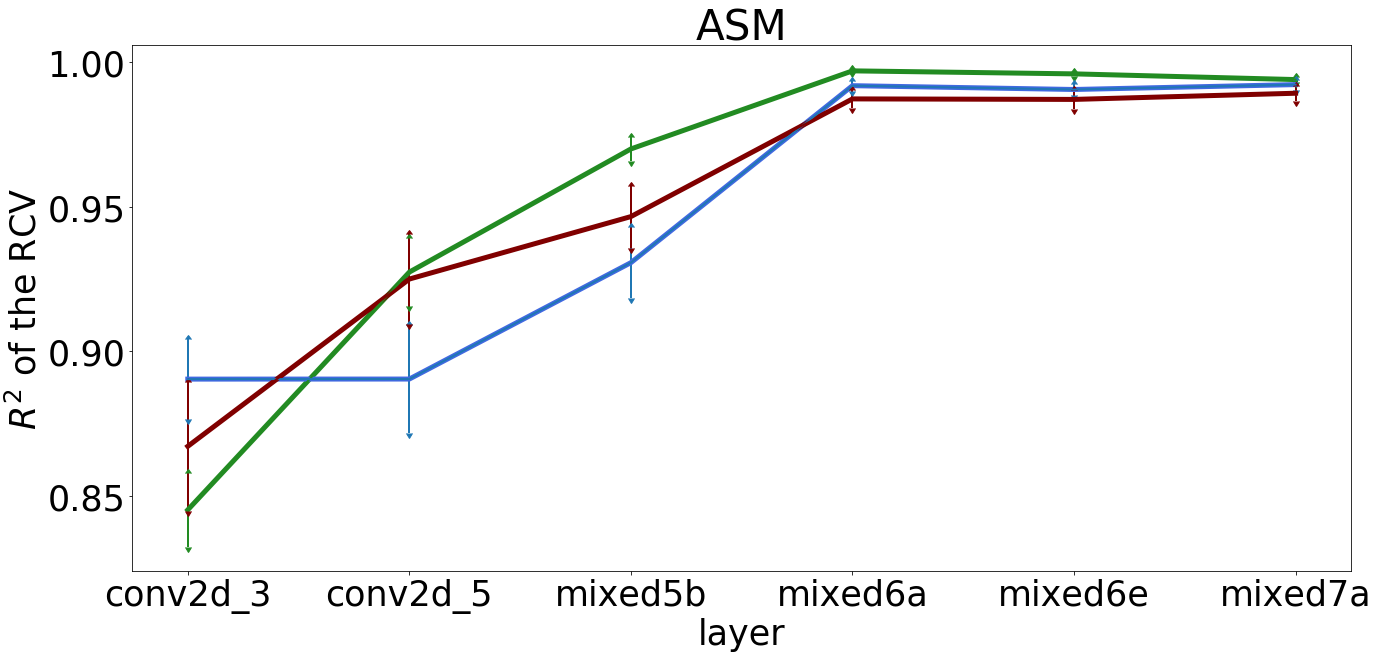

/home/mara/venv/local/lib/python2.7/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


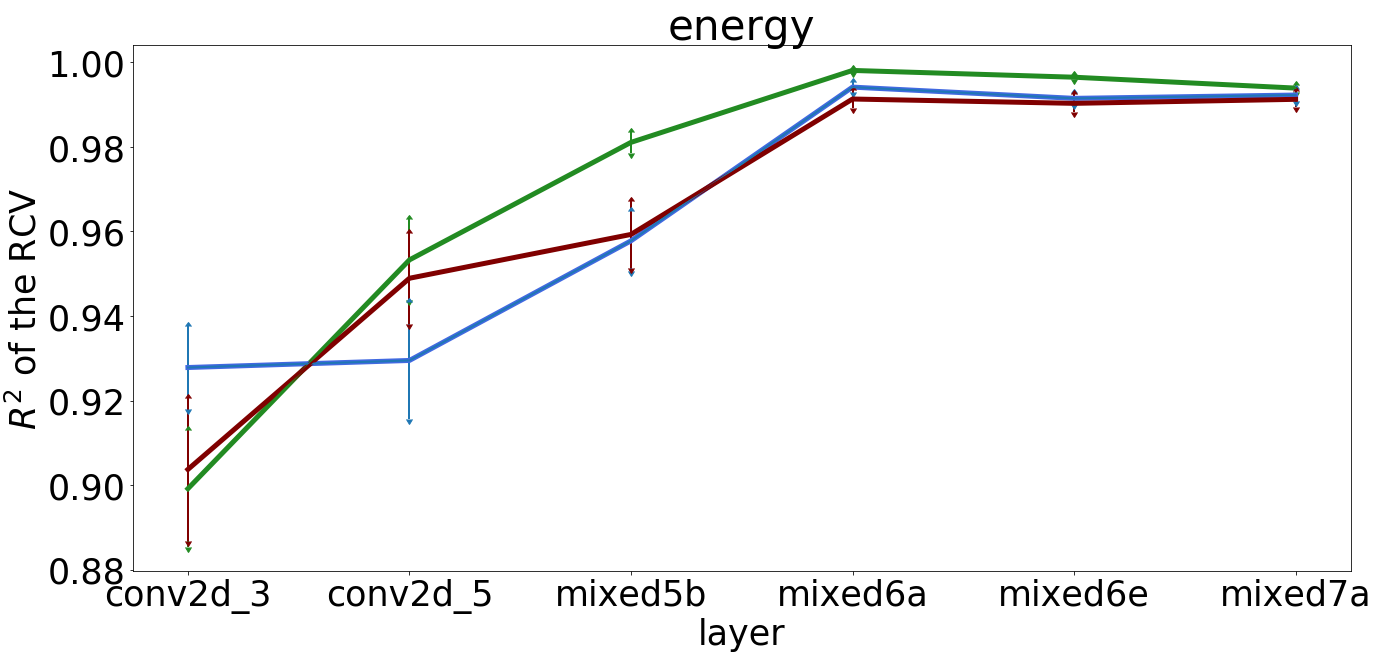

/home/mara/venv/local/lib/python2.7/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


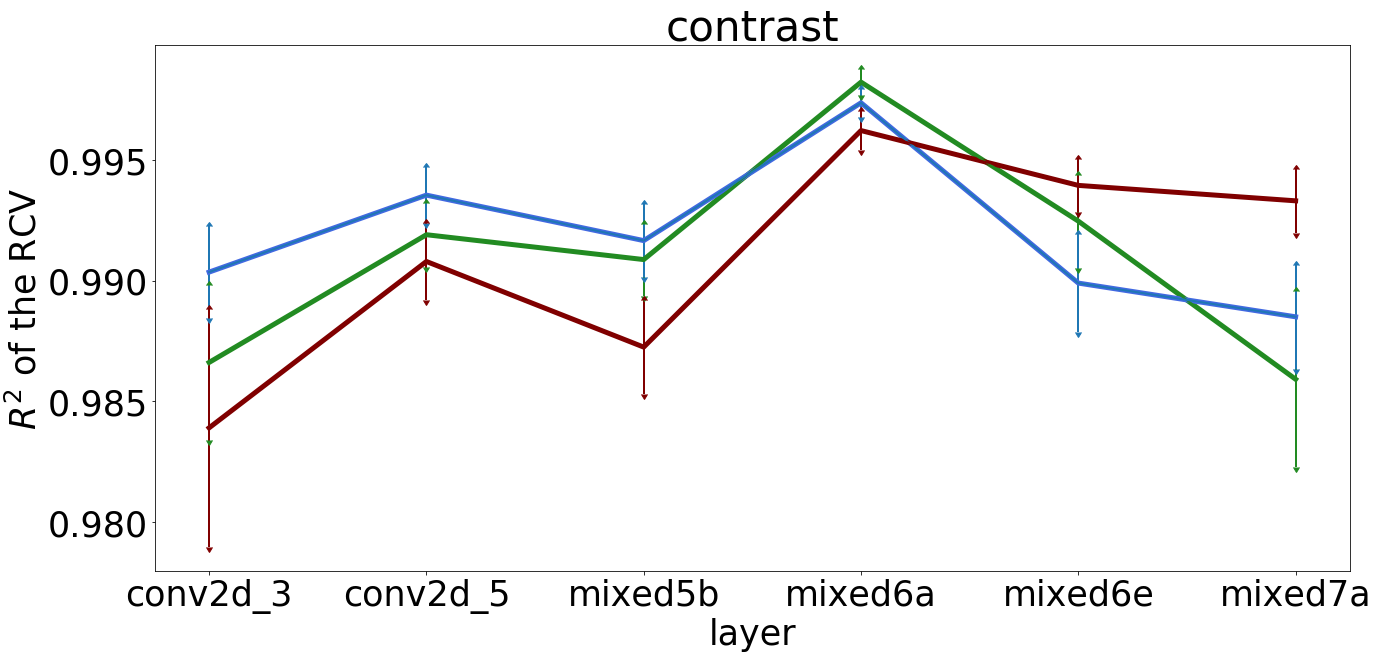

/home/mara/venv/local/lib/python2.7/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


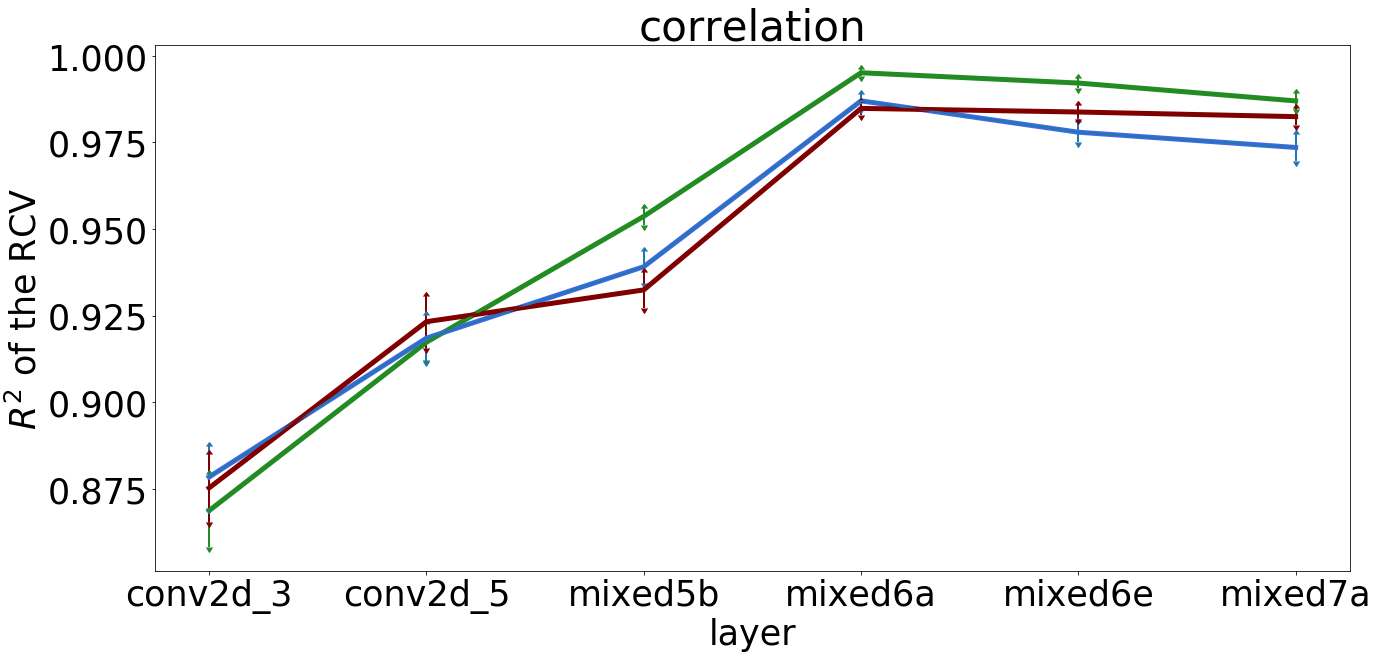

/home/mara/venv/local/lib/python2.7/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


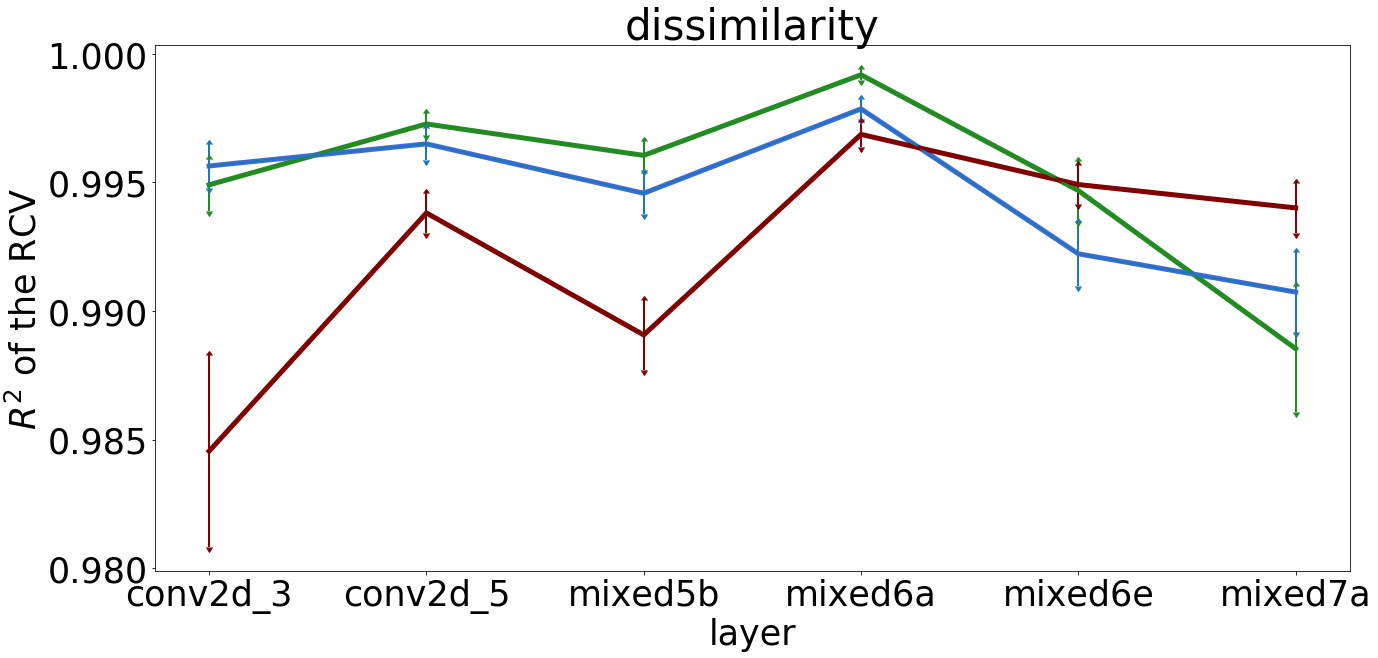

In [275]:
# PLOTTING

plt.rcParams['figure.figsize']=(20,10)
plt.rcParams['font.size']=(35)
plt.rcParams.update({'figure.autolayout': True})
for concept in concepts:
    plt.figure()
    plt.title(concept)
    #plt.plot(rand_mean_stats[concept])
    std_all_corr=finetuned_std_stats[concept]
    mean_all_corr = finetuned_mean_stats[concept]
    #ci= [1.96 * (std_all_corr[i] / np.sqrt(3)) for i in range(len(std_all_corr))]
    plt.plot(np.arange(0,6), mean_all_corr, color='forestgreen',linewidth=5.0)
    #plt.fill_between(np.arange(0,6), [mean_all_corr[i] + ci[i] for i in range(0,6)], [mean_all_corr[i] - ci[i] for i in range(0,6)], color='lightgreen', alpha=0.8)
    plt.errorbar(np.arange(0,6),
                 mean_all_corr, 
                 std_all_corr/np.sqrt(10), 
                 color='forestgreen', 
                 linewidth=2.,
                 uplims=True, 
                 lolims=True)
    
    
    std_all_corr=pretrained_std_stats[concept]
    mean_all_corr = pretrained_mean_stats[concept]
    #ci= [1.96 * (std_all_corr[i] / np.sqrt(3)) for i in range(len(std_all_corr))]
    plt.plot(np.arange(0,6), mean_all_corr, color='royalblue', linewidth=5.0)
    #plt.fill_between(np.arange(0,6), [mean_all_corr[i] + ci[i] for i in range(0,6)], [mean_all_corr[i] - ci[i] for i in range(0,6)], color='skyblue', alpha=0.5)
    plt.errorbar(np.arange(0,6), 
                 mean_all_corr,
                 std_all_corr/np.sqrt(10), 
                 linewidth=2.,
                 uplims=True, 
                 lolims=True) 
    
   
    std_all_corr=random_std_stats[concept]
    mean_all_corr = random_mean_stats[concept]
    #ci= [1.96 * (std_all_corr[i] / np.sqrt(3)) for i in range(len(std_all_corr))]

    plt.plot(np.arange(0,6), mean_all_corr, color='maroon',linewidth=5.0)
    #plt.fill_between(np.arange(0,6), [mean_all_corr[i] + ci[i] for i in range(0,6)], [mean_all_corr[i] - ci[i] for i in range(0,6)], color='lightcoral', alpha=0.5)
    plt.errorbar(np.arange(0,6), 
                 mean_all_corr,
                 #fmt='ro',
                 yerr=std_all_corr/np.sqrt(10), 
                 color='maroon', linewidth=2.,
                 uplims=True, 
                 lolims=True)
    #plt.plot(pretrained_mean_stats[concept], color='green')
        
    plt.xticks(np.arange(6), ['conv2d_3', 'conv2d_5', 'mixed5b', 
                      #'mixed1', 'mixed2',
                      'mixed6a',#'mixed4', 'mixed5',
                      'mixed6e', 'mixed7a',
                      #'mixed8', 
                      ])
    plt.ylabel('$R^2$ of the RCV')
    plt.xlabel('layer')